In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (15,10)
mpl.rcParams['font.size'] = 16  # Set the font size for all elements


from copy import deepcopy


#For random forest for time series:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

#For metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Having to import from subfolders of parent directories is a nightmare
import sys
import os
current = os.path.dirname(os.path.realpath("Single-House-Optimization.py"))
parent = os.path.dirname(current)
sys.path.append(parent+"\Functions")

#From Functions folder
from LoadSeries import load_series, moving_average
from Merge import merge
from Battery import Battery
from DPModel import DP, DP_carb, DP_both
from Logic import logic_rollout, action_rollout, pred_logic_rollout, print_price_summary, logic_series_print
from MPC import MPC, MPC_carb, MPC_both, MPCModel
from Predictions import RF
from SARIMAfx import SARIMA

C:\Users\alexa\AppData\Roaming\Python\Python39\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [21]:
class single_house_opt(SARIMA):
    
    def __init__(self, house, start_date='2022-06-19 00:00:00', end_date='2022-06-25 23:00:00', bat_capacity=13, max_charge=7, 
                 stepsize=2, opt_size_prod=1, opt_lags_prod=[1], opt_params_prod={},
                 opt_size_cons=1, opt_lags_cons=[1], opt_params_cons={},
                 opt_size_emis=1, opt_lags_emis=[1], opt_params_emis={}):
        
        self.house = house
        self.start_date = start_date
        self.end_date = end_date
        self.bat_capacity = bat_capacity
        self.max_charge = max_charge
        self.stepsize = stepsize

        self.merged = merge(str(self.house))
        self.sarima_model = SARIMA(self.house)
        
        working_month = self.merged.loc[start_date:end_date].index[0].month
        tax = 0.9 if working_month<=6 else (0.763 if working_month <=9 else 0.723) #Only correct for 2022
        
        self.rf_model = RF(self.house)
        
        
        #Change so RF has optimal hyperparameters attributed to start and end date
        prodforc = self.rf_model.get_forecaster(opt_lags_prod,opt_params_prod)  
        consforc = self.rf_model.get_forecaster(opt_lags_cons,opt_params_cons)  
        emisforc = self.rf_model.get_forecaster(opt_lags_emis,opt_params_emis)  
        
        self.rf_model.set_forecaster("p",opt_size_prod,prodforc)
        self.rf_model.set_forecaster("c",opt_size_cons,consforc)
        self.rf_model.set_forecaster("e",opt_size_emis,emisforc)
        
        
        
        self.last_results=pd.DataFrame()
    
        self.N = len(pd.date_range(start=self.start_date,end=self.end_date,freq="h"))
        remainder = self.N%24

        if remainder==0:
            print(f"Period is of size {self.N} hours = {self.N//24} days\nPeriod from {self.start_date} to {self.end_date} for house {self.house}")
        elif remainder==1:
            print(f"Period of size {self.N} hours = {self.N//24} days and {remainder} hour\nPeriod from {self.start_date} to {self.end_date}")
        else:
            print(f"Period of size {self.N} hours = {self.N//24} days and {remainder} hours\nPeriod from {self.start_date} to {self.end_date}")
        print('--- \n')
        
    def opt_results(self):
     
        num_loops = int(np.ceil(self.N/self.stepsize))
        remainder = self.N%self.stepsize
        length = self.stepsize
        
        Start_i = self.start_date
        merges = pd.DataFrame() 
        sarima = pd.DataFrame()
        ranfor = pd.DataFrame()
        
        for i in range(num_loops):
            if i == num_loops-1:
                length = length if remainder == 0 else remainder
                
            End_i = pd.date_range(start=Start_i, periods=24, freq="h")[-1]

            merged_i = self.merged.loc[Start_i:End_i]
            print(f"Loop number {i+1} of {num_loops}")
            print(f"Predicting period from {Start_i} to {End_i} (n = {len(pd.date_range(Start_i, End_i, freq='H'))})")          
            
            #pred_i_sar = self.sarima_model.SARIMA(Start_i, End_i)
            pred_i_rf = self.rf_model.get_predictions(Start_i, End_i)      
            
            
            
            Start_i = pd.date_range(start=Start_i,periods=length+1,freq="h")[-1]
            
            merges=pd.concat([merges,merged_i])
            #sarima=pd.concat([sarima,pred_i_sar])
            ranfor=pd.concat([ranfor,pred_i_rf])
            print()

            self.last_results=(merges,ranfor)
        return self.last_results

# April

In [3]:
opt_size_prod=1800
opt_lags_prod=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
opt_params_prod={'n_estimators': 402, 'max_depth': 13, 'max_features': 'log2'}

opt_size_cons=100
opt_lags_cons=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
opt_params_cons={'n_estimators': 236, 'max_depth': 20, 'max_features': 'sqrt'}

opt_size_emis=100
opt_lags_emis=[1]
opt_params_emis={'n_estimators': 720, 'max_depth': 10, 'max_features': 'sqrt'}

sho = single_house_opt('h16',start_date='2022-04-01 00:00:00', end_date='2022-04-03 23:00:00',
                       opt_size_prod=opt_size_prod, opt_lags_prod=opt_lags_prod, opt_params_prod=opt_params_prod,
                       opt_size_cons=opt_size_cons, opt_lags_cons=opt_lags_cons, opt_params_cons=opt_params_cons,
                       opt_size_emis=opt_size_emis, opt_lags_emis=opt_lags_emis, opt_params_emis=opt_params_emis) 

merges,ranfor = sho.opt_results()

Period is of size 72 hours = 3 days
Period from 2022-04-01 00:00:00 to 2022-04-03 23:00:00 for house h16
--- 

Loop number 1 of 36
Predicting period from 2022-04-01 00:00:00 to 2022-04-01 23:00:00 (n = 24)

Loop number 2 of 36
Predicting period from 2022-04-01 02:00:00 to 2022-04-02 01:00:00 (n = 24)

Loop number 3 of 36
Predicting period from 2022-04-01 04:00:00 to 2022-04-02 03:00:00 (n = 24)

Loop number 4 of 36
Predicting period from 2022-04-01 06:00:00 to 2022-04-02 05:00:00 (n = 24)

Loop number 5 of 36
Predicting period from 2022-04-01 08:00:00 to 2022-04-02 07:00:00 (n = 24)

Loop number 6 of 36
Predicting period from 2022-04-01 10:00:00 to 2022-04-02 09:00:00 (n = 24)

Loop number 7 of 36
Predicting period from 2022-04-01 12:00:00 to 2022-04-02 11:00:00 (n = 24)

Loop number 8 of 36
Predicting period from 2022-04-01 14:00:00 to 2022-04-02 13:00:00 (n = 24)

Loop number 9 of 36
Predicting period from 2022-04-01 16:00:00 to 2022-04-02 15:00:00 (n = 24)

Loop number 10 of 36
Pred

NameError: name 'last_results' is not defined

In [35]:
merges,ranfor = sho.last_results

true_prod = merges["prod_h16"].to_numpy()
true_cons = merges["cons_h16"].to_numpy()
true_carb = merges["CO2Emission"].to_numpy()

rf_prod = ranfor["prod_h16"].to_numpy()
rf_cons = ranfor["cons_h16"].to_numpy()
rf_carb = ranfor["CO2Emission"].to_numpy()

In [61]:
mses_prod_apr = pd.read_csv("SARIMA-results/mses_prod_apr.csv")
mses_cons_apr = pd.read_csv("SARIMA-results/mses_cons_apr.csv")
mses_carb_apr = pd.read_csv("SARIMA-results/mses_carb_apr.csv")

prod_rmses_sa = np.sqrt(mses_prod_apr["x"].to_numpy())
cons_rmses_sa = np.sqrt(mses_cons_apr["x"].to_numpy())
carb_rmses_sa = np.sqrt(mses_carb_apr["x"].to_numpy())

prod_rmse_sa = np.mean(prod_rmses_sa)
cons_rmse_sa = np.mean(cons_rmses_sa)
carb_rmse_sa = np.mean(carb_rmses_sa)

In [62]:
prod_rmses = np.empty((12*3))
cons_rmses = np.empty((12*3))
carb_rmses = np.empty((12*3))

for i in range(12*3):
    prod_rmses[i]=np.sqrt(np.mean(np.square(true_prod[i*24:(i+1)*24]-rf_prod[i*24:(i+1)*24])))
    cons_rmses[i]=np.sqrt(np.mean(np.square(true_cons[i*24:(i+1)*24]-rf_cons[i*24:(i+1)*24])))
    carb_rmses[i]=np.sqrt(np.mean(np.square(true_carb[i*24:(i+1)*24]-rf_carb[i*24:(i+1)*24])))

prod_rmse = np.mean(prod_rmses)
cons_rmse = np.mean(cons_rmses)
carb_rmse = np.mean(carb_rmses)

print(f"Prod RMSE RF: {prod_rmse}")
print(f"Cons RMSE RF: {cons_rmse}")
print(f"Carb RMSE RF: {carb_rmse}")
print()
print(f"Prod RMSE SA: {prod_rmse_sa}")
print(f"Cons RMSE SA: {cons_rmse_sa}")
print(f"Carb RMSE SA: {carb_rmse_sa}")

Prod RMSE RF: 3.087103001013286
Cons RMSE RF: 1.6724969920232906
Carb RMSE RF: 71.86636185606876

Prod RMSE SA: 3.6150701923867
Cons RMSE SA: 1.6541753870223124
Carb RMSE SA: 62.83504159864937


# October

In [25]:
opt_size_prod=500
opt_lags_prod=[1]
opt_params_prod={'n_estimators': 246, 'max_depth': 14, 'max_features': 'sqrt'}

opt_size_cons=2000
opt_lags_cons=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
opt_params_cons={'n_estimators': 246, 'max_depth': 14, 'max_features': 'sqrt'}

opt_size_emis=100
opt_lags_emis=[1]
opt_params_emis={'n_estimators': 402, 'max_depth': 13, 'max_features': 'log2'}

sho_oct = single_house_opt('h16',start_date='2022-10-01 00:00:00', end_date='2022-10-03 23:00:00',
                       opt_size_prod=opt_size_prod, opt_lags_prod=opt_lags_prod, opt_params_prod=opt_params_prod,
                       opt_size_cons=opt_size_cons, opt_lags_cons=opt_lags_cons, opt_params_cons=opt_params_cons,
                       opt_size_emis=opt_size_emis, opt_lags_emis=opt_lags_emis, opt_params_emis=opt_params_emis) 

merges_oct,ranfor_oct = sho_oct.opt_results()

Period is of size 72 hours = 3 days
Period from 2022-10-01 00:00:00 to 2022-10-03 23:00:00 for house h16
--- 

Loop number 1 of 36
Predicting period from 2022-10-01 00:00:00 to 2022-10-01 23:00:00 (n = 24)

Loop number 2 of 36
Predicting period from 2022-10-01 02:00:00 to 2022-10-02 01:00:00 (n = 24)

Loop number 3 of 36
Predicting period from 2022-10-01 04:00:00 to 2022-10-02 03:00:00 (n = 24)

Loop number 4 of 36
Predicting period from 2022-10-01 06:00:00 to 2022-10-02 05:00:00 (n = 24)

Loop number 5 of 36
Predicting period from 2022-10-01 08:00:00 to 2022-10-02 07:00:00 (n = 24)

Loop number 6 of 36
Predicting period from 2022-10-01 10:00:00 to 2022-10-02 09:00:00 (n = 24)

Loop number 7 of 36
Predicting period from 2022-10-01 12:00:00 to 2022-10-02 11:00:00 (n = 24)

Loop number 8 of 36
Predicting period from 2022-10-01 14:00:00 to 2022-10-02 13:00:00 (n = 24)

Loop number 9 of 36
Predicting period from 2022-10-01 16:00:00 to 2022-10-02 15:00:00 (n = 24)

Loop number 10 of 36
Pred

In [32]:
merges_oct,ranfor_oct = sho_oct.last_results

true_prod_oct = merges_oct["prod_h16"].to_numpy()
true_cons_oct = merges_oct["cons_h16"].to_numpy()
true_carb_oct = merges_oct["CO2Emission"].to_numpy()

rf_prod_oct = ranfor_oct["prod_h16"].to_numpy()
rf_cons_oct = ranfor_oct["cons_h16"].to_numpy()
rf_carb_oct = ranfor_oct["CO2Emission"].to_numpy()

In [63]:
mses_prod_oct = pd.read_csv("SARIMA-results/mses_prod_oct.csv")
mses_cons_oct = pd.read_csv("SARIMA-results/mses_cons_oct.csv")
mses_carb_oct = pd.read_csv("SARIMA-results/mses_carb_oct.csv")

prod_rmses_oct_sa = np.sqrt(mses_prod_oct["x"].to_numpy())
cons_rmses_oct_sa = np.sqrt(mses_cons_oct["x"].to_numpy())
carb_rmses_oct_sa = np.sqrt(mses_carb_oct["x"].to_numpy())

prod_rmse_oct_sa = np.mean(prod_rmses_oct_sa)
cons_rmse_oct_sa = np.mean(cons_rmses_oct_sa)
carb_rmse_oct_sa = np.mean(carb_rmses_oct_sa)

In [64]:
prod_rmses_oct = np.empty((12*3))
cons_rmses_oct = np.empty((12*3))
carb_rmses_oct = np.empty((12*3))

for i in range(12*3):
    prod_rmses_oct[i]=np.sqrt(np.mean(np.square(true_prod_oct[i*24:(i+1)*24]-rf_prod_oct[i*24:(i+1)*24])))
    cons_rmses_oct[i]=np.sqrt(np.mean(np.square(true_cons_oct[i*24:(i+1)*24]-rf_cons_oct[i*24:(i+1)*24])))
    carb_rmses_oct[i]=np.sqrt(np.mean(np.square(true_carb_oct[i*24:(i+1)*24]-rf_carb_oct[i*24:(i+1)*24])))

prod_rmse_oct = np.mean(prod_rmses_oct)
cons_rmse_oct = np.mean(cons_rmses_oct)
carb_rmse_oct = np.mean(carb_rmses_oct)

print(f"Prod RMSE: {prod_rmse_oct}")
print(f"Cons RMSE: {cons_rmse_oct}")
print(f"Carb RMSE: {carb_rmse_oct}")
print()
print(f"Prod RMSE SA: {prod_rmse_oct_sa}")
print(f"Cons RMSE SA: {cons_rmse_oct_sa}")
print(f"Carb RMSE SA: {carb_rmse_oct_sa}")

Prod RMSE: 4.158105945266424
Cons RMSE: 1.192353112595873
Carb RMSE: 52.775406510558796

Prod RMSE SA: 3.858667078608641
Cons RMSE SA: 1.5566479086921319
Carb RMSE SA: 49.945167882727084


In [48]:
sns.set(style="darkgrid")
sns.set_context(rc={"xtick.labelsize":12,"axes.labelsize":15})
plt.rcParams["figure.figsize"] = (20,3)

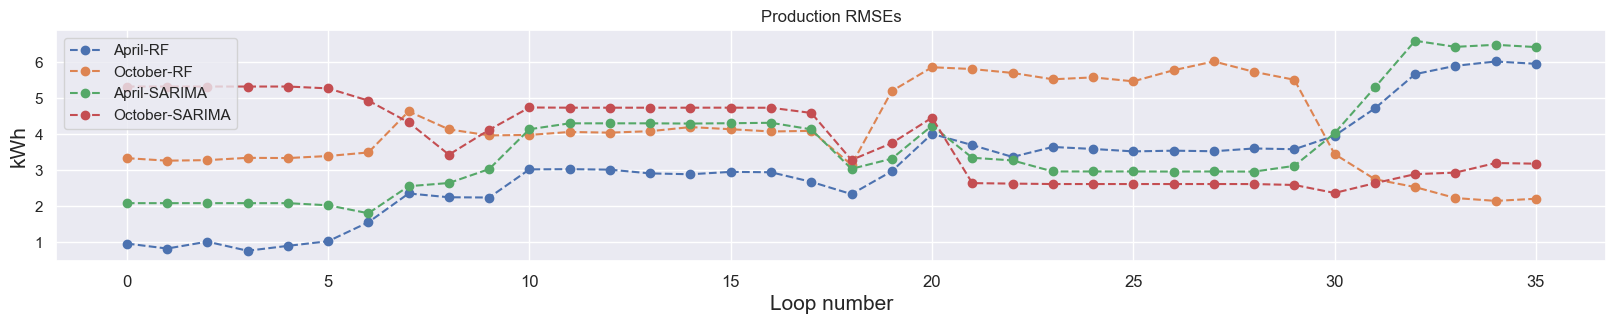

In [74]:
plt.plot(prod_rmses,marker='o',linestyle="--")
plt.plot(prod_rmses_oct,marker='o',linestyle="--")
plt.plot(prod_rmses_sa,marker='o',linestyle="--")
plt.plot(prod_rmses_oct_sa,marker='o',linestyle="--")
plt.ylabel("kWh")
plt.xlabel("Loop number")
plt.legend(["April-RF","October-RF","April-SARIMA","October-SARIMA"])
plt.title("Production RMSEs")
plt.savefig("ProductionRMSEs.png")
plt.show()

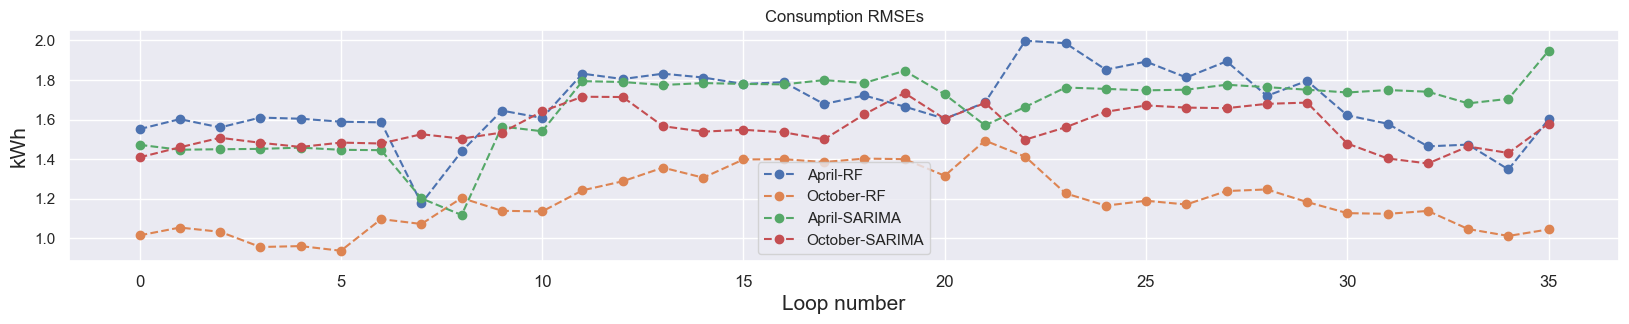

In [75]:
plt.plot(cons_rmses,marker='o',linestyle="--")
plt.plot(cons_rmses_oct,marker='o',linestyle="--")
plt.plot(cons_rmses_sa,marker='o',linestyle="--")
plt.plot(cons_rmses_oct_sa,marker='o',linestyle="--")
plt.ylabel("kWh")
plt.xlabel("Loop number")
plt.legend(["April-RF","October-RF","April-SARIMA","October-SARIMA"])
plt.title("Consumption RMSEs")
plt.savefig("ConsumptionRMSEs.png")
plt.show()

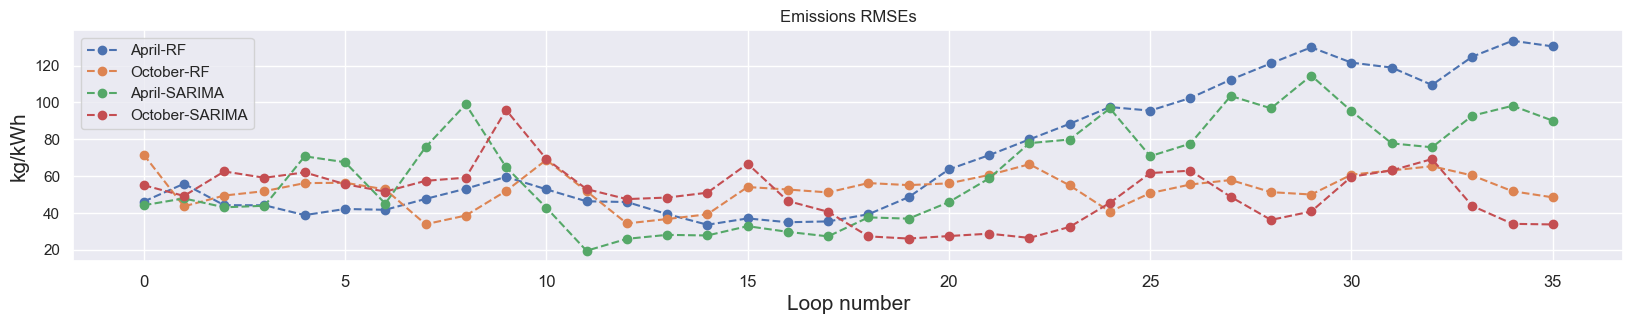

In [76]:
plt.plot(carb_rmses,marker='o',linestyle="--")
plt.plot(carb_rmses_oct,marker='o',linestyle="--")
plt.plot(carb_rmses_sa,marker='o',linestyle="--")
plt.plot(carb_rmses_oct_sa,marker='o',linestyle="--")
plt.ylabel("kg/kWh")
plt.xlabel("Loop number")
plt.legend(["April-RF","October-RF","April-SARIMA","October-SARIMA"])
plt.title("Emissions RMSEs")
plt.savefig("EmissionsRMSEs.png")
plt.show()